# Parameter plotting with LiionDB

In this notebook we will show how to plot and compare parameters in a loop.
A simplified interactive GUI is available online at [**www.liiondb.com**](www.liiondb.com)

---
* LiionDB is a database of DFN-type battery model parameters that accompanies the review manuscript: [**Parameterising Continuum-Level Li-ion Battery Models**.](https://www.overleaf.com/project/5ed63d9378cbf700018a2018).
* If you use LiionDB in your work, please cite our paper at: [doi.org](https://www.doi.org/).
---

Start by cloning the liiondb library into this notebook & loading modules

In [1]:
%rm -rf liiondb #uncomment if refreshing
!git clone https://github.com/ndrewwang/liiondb.git

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import liiondb.functions.fn_db as fn_db
dfndb, db_connection = fn_db.liiondb()

Cloning into 'liiondb'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 212 (delta 97), reused 87 (delta 32), pack-reused 0
Receiving objects: 100% (212/212), 179.90 KiB | 2.40 MiB/s, done.
Resolving deltas: 100% (97/97), done.


---
## First, define function `plot_loop()` that loops and plots all data_id's from a given list:

In [2]:
def plot_loop(id_list,temperature):
    #plot data id list in a loop fashion
    %matplotlib inline
    from matplotlib.font_manager import FontProperties
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
    import importlib

    # For parameters with temperature dependence
    T = temperature #K
    
    # Plot display settings
    w = 5
    h = 4
    d = 100
    plt.figure(figsize=(w, h), dpi=d)
    
    # Label font sizes
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 15

    # Looping through and plotting
    for i in range(len(id_list)):
        data_id = id_list[i]

        QUERY = 'SELECT * FROM data WHERE data_id = %s;' %str(data_id)

        df = pd.read_sql(QUERY,dfndb)
        
        # Query and assign the legend and axes label strings
        paper_id = df.paper_id[0]
        QUERY = 'SELECT paper.paper_tag FROM paper WHERE paper_id = %s;' %str(paper_id)
        paper_string = pd.read_sql(QUERY,dfndb).paper_tag[0]
        material_id = df.material_id[0]
        QUERY = 'SELECT material.name FROM material WHERE material_id = %s;' %str(material_id)
        material_string = pd.read_sql(QUERY,dfndb).name[0]
        leg_string = material_string + ', '+ paper_string
        parameter_id = df.parameter_id[0]
        QUERY = 'SELECT * FROM parameter WHERE parameter_id = %s;' %str(parameter_id)
        paramdf = pd.read_sql(QUERY,dfndb)
        xlabel = '['+paramdf.units_input[0]+']'
        y_unit = paramdf.units_output[0]
        y_param = paramdf.name[0]
        ylabel = y_param + ' ' + '['+y_unit+']'

        # Reading the raw data either in value, array, or function format
        csv_data = fn_db.read_data(df) 
        import parameter_from_db #import/reload parameter_from_db.py file
        importlib.reload(parameter_from_db)

        #Plots based on the valid input range defined in the database (with some small padding)
        if df.raw_data_class[0] == 'function':
            c_low = float(df.input_range.to_numpy()[0].lower)+0.001
            c_max = float(df.input_range.to_numpy()[0].upper)-0.001
            c = np.linspace(c_low,c_max) #SI Units mol/m3
            try:
                y = parameter_from_db.function(c,T) #run the function just written from the database
            except:
                y = parameter_from_db.function(c)
            x = c
            y = y
            plt.plot(x,y,'-',label=leg_string)

        elif df.raw_data_class[0] == 'array':
            c = csv_data[:,0]
            y = csv_data[:,1]
            x = c
            y = y
            plt.plot(x,y,'-',label=leg_string)

        elif df.raw_data_class[0] == 'value':
            n = 10
            y = float(csv_data)
            y = y*np.linspace(1,1,n)
            c_low = float(df.input_range.to_numpy()[0].lower)
            c_max = float(df.input_range.to_numpy()[0].upper)
            c = np.linspace(c_low,c_max,n) #SI Units mol/m3
            x = c
            y = y
            plt.plot(x,y,'-',label=leg_string)


        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
    
    fontP = FontProperties()
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    plt.rcParams['axes.linewidth'] = 1

    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    fig1 = plt.gcf()
    plt.show()

---
# Plotting examples:

## 1. Plot all LFP OCV curves:

First, query and show the resulting matches

In [3]:
QUERY = '''
        SELECT DISTINCT data.data_id,parameter.symbol,parameter.name as parameter, material.name as material,data.raw_data, parameter.units_input, parameter.units_output, paper.paper_tag, paper.doi
        FROM data
        JOIN paper ON paper.paper_id = data.paper_id
        JOIN material ON material.material_id = data.material_id
        JOIN parameter ON parameter.parameter_id = data.parameter_id
        WHERE parameter.name = 'half cell ocv'
        AND material.lfp = 1
        '''
df = pd.read_sql(QUERY,dfndb)
id_list = df['data_id'].to_list()
df

,data_id,symbol,parameter,material,raw_data,units_input,units_output,paper_tag,doi
0,313,${U_\text{eq}}$,half cell ocv,LFP,see function,lithiation stoich,V,Kashkooli2016,10.1016/j.jpowsour.2015.12.134
1,325,${U_\text{eq}}$,half cell ocv,LFP,see function,lithiation stoich,V,Farkhondeh2014,10.1149/2.094401jes
2,326,${U_\text{eq}}$,half cell ocv,LFP,see function,lithiation stoich,V,Farkhondeh2014,10.1149/2.094401jes
3,371,${U_\text{eq}}$,half cell ocv,LFP,see function,lithiation stoich,V,Delacourt2011,10.1016/j.electacta.2011.03.030
4,377,${U_\text{eq}}$,half cell ocv,LFP,"{{0.021551724137931026,3.8131297709923664},{0....",lithiation stoich,V,Prada2012,10.1149/2.064209jes
5,378,${U_\text{eq}}$,half cell ocv,LFP,"{{0.021551724137931026,3.483358778625954},{0.0...",lithiation stoich,V,Prada2012,10.1149/2.064209jes
6,511,${U_\text{eq}}$,half cell ocv,LFP,see function,lithiation stoich,V,Srinivasan2004a,10.1149/1.1785012
7,512,${U_\text{eq}}$,half cell ocv,LFP,"{{0.0015931618306192494,3.5052391799544416},{0...",lithiation stoich,V,Srinivasan2004a,10.1149/1.1785012
8,830,${U_\text{eq}}$,half cell ocv,LFP,see function,lithiation stoich,V,Thorat2011,10.1149/2.001111jes


Now we use `plot_loop()` to plot all of these together:

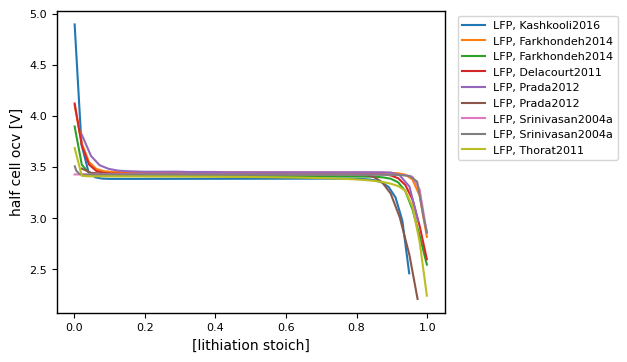

In [42]:
plot_loop(id_list,298)

## 2. Plot all conductivities for LiFP6 containing electrolytes at 10 deg C:

First, query and show the resulting matches, limited to the top 10

In [43]:
QUERY = '''
        SELECT DISTINCT data.data_id,parameter.symbol,parameter.name as parameter, material.name as material,data.raw_data, parameter.units_input, parameter.units_output, paper.paper_tag, paper.doi
        FROM data
        JOIN paper ON paper.paper_id = data.paper_id
        JOIN material ON material.material_id = data.material_id
        JOIN parameter ON parameter.parameter_id = data.parameter_id
        WHERE parameter.name = 'ionic conductivity'
        AND material.lipf6 = 1
        AND 283 BETWEEN lower(data.temp_range) AND upper(data.temp_range)
        LIMIT 10
        '''
df = pd.read_sql(QUERY,dfndb)
id_list = df['data_id'].to_list()
df

,data_id,symbol,parameter,material,raw_data,units_input,units_output,paper_tag,doi
0,35,$\kappa$,ionic conductivity,LiPF6:EC:EMC 1:1,see function,mol*m^-3,S*m^-1,Ecker2015,10.1149/2.0551509jes
1,54,$\kappa$,ionic conductivity,LiPF6:EC:DMC:EMC 1:1:1,see function,mol*m^-3,S*m^-1,Schmalstieg2018,10.1149/2.0321816jes
2,107,$\kappa$,ionic conductivity,LiPF6:EC:DMC 1:1,see function,mol*m^-3,S*m^-1,Landesfeind2019,10.1149/2.0571912jes
3,111,$\kappa$,ionic conductivity,LiPF6:EC:EMC 3:7,see function,mol*m^-3,S*m^-1,Landesfeind2019,10.1149/2.0571912jes
4,115,$\kappa$,ionic conductivity,LiPF6:EMC:FEC 19:1,see function,mol*m^-3,S*m^-1,Landesfeind2019,10.1149/2.0571912jes
5,163,$\kappa$,ionic conductivity,LiPF6:EC:DEC 1:1,see function,mol*m^-3,S*m^-1,Lundgren2014,10.1149/2.0641503jes
6,250,$\kappa$,ionic conductivity,LiPF6:EMC,"{{508.8637133501448,0.11042944785276054},{1067...",mol*m^-3,S*m^-1,Logan2018,10.1149/2.0471814jes
7,255,$\kappa$,ionic conductivity,LiPF6:DMC,"{{567.2725999531823,0.22085889570552156},{1133...",mol*m^-3,S*m^-1,Logan2018,10.1149/2.0471814jes
8,260,$\kappa$,ionic conductivity,LiPF6:EC:EMC 1:9,"{{544.6875,0.3067484662576687},{1128.75,0.4539...",mol*m^-3,S*m^-1,Logan2018,10.1149/2.0471814jes
9,265,$\kappa$,ionic conductivity,LiPF6:EC:DMC 1:9,"{{582.1002299533166,0.5243902439024399},{1159....",mol*m^-3,S*m^-1,Logan2018,10.1149/2.0471814jes


Now we use `plot_loop()` to plot all of these together:

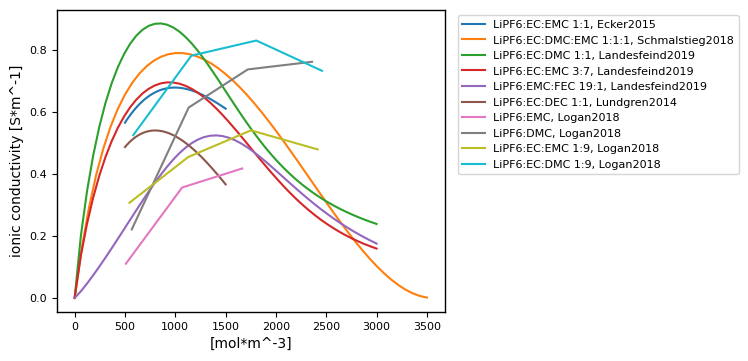

In [44]:
plot_loop(id_list,283) #313 is 10 degrees